### Universenet의 Confidence score에 따른 mAP성능 차이
|confidence threshold|LB mAP50|
|:---:|:---:|
|0.05|0.6383|
|0.1|0.6351|
|0.2|0.6192|

- Inference 시 universenet의 confidence threshold를 높였을 때 mAP 값이 떨어졌다.
- confidence threshold를 높이면 모델이 예측하는 bbox의 개수가 줄어든다.
- 전체 예측 bbox 개수가 줄어들었으므로, <span style='color:orange'>recall이 유지된다면</span> mAP는 올라가야 한다.
- 허나 mAP가 떨어졌고, 이는 confidence threshold를 높이면서 recall이 떨어졌다(정답에 근접하는 bbox 자체를 검출하지 못했음)는 얘기이다.
- 그렇다면, 모델이 낮은 confidence로 예측했던 bbox 중에 GT인 bbox가 있다는 얘기이다.
- 낮은 confidence로 예측한 bbox의 카테고리와, bbox의 영역은 어떻게 될까?

In [8]:
# CSV 파일 불러오기
import pandas as pd
from tqdm import tqdm

universenet_preds = pd.read_csv("/opt/ml/UniverseNet/work_dir/output.csv")

category_distribution_base = [0 for _ in range(10)]
category_distribution_under_threshold = [0 for _ in range(10)]

for preds in universenet_preds['PredictionString']:
    splitted_preds = preds.split()
    
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])

        if confidence_score > 0.05: # baseline. LB mAP가 0.6383인 모델
            category_distribution_base[category_id] += 1
        
        if confidence_score < 0.2:
            category_distribution_under_threshold[category_id] += 1
        
print('모델이 예측한 모든 결과 (no confidence threshold)')
print(category_distribution_base, 'total : ', sum(category_distribution_base))
print('-' * 100)
print('모델이 예측한 모든 결과에서, confidence score가 0.2 미만인 box')
print(category_distribution_under_threshold, 'total : ', sum(category_distribution_under_threshold))

모델이 예측한 모든 결과 (no confidence threshold)
[51718, 48752, 8585, 8729, 7174, 26047, 11729, 38139, 2067, 6039] total :  208979
----------------------------------------------------------------------------------------------------
모델이 예측한 모든 결과에서, confidence score가 0.2 미만인 box
[41252, 32873, 6546, 6592, 4927, 18851, 9047, 27779, 1782, 5084] total :  154733


- 모델이 예측한 결과 중에서, confidence score가 0.2 미만인 bbox가 대부분이다.
- 0.2 threshold일 때 보다, 0.05 threshold일 때는 자그마치 15만개의 bbox를 더 예측하니 mAP 향상 폭이 적을 수 밖에 없다.
- mAP를 향상시키려면 저 많은 bbox를 걸러낼 수 있는 기준이 필요한데,,
- 그 기준이 bbox의 면적이라면 어떨까?

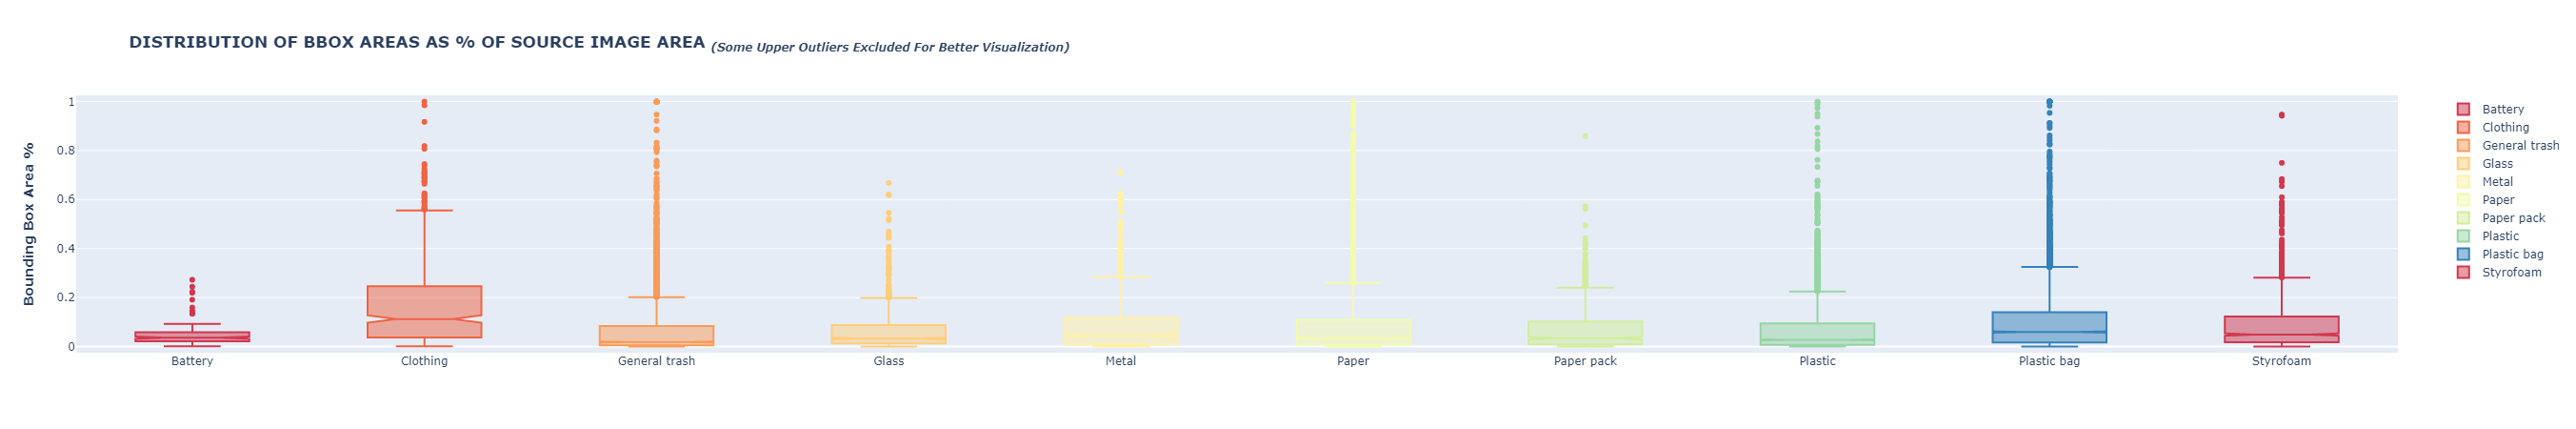

In [9]:
from IPython.display import Image

Image('/opt/ml/dev/newplot.png')

- 우리는 대회 초기 EDA를 통해, 학습 데이터에 존재하는 대부분의 bbox 면적이 중간 이하(0.4)라는 것을 알 수 있었다.
- 실제 모델이 예측한 bbox의 면적을 보았을 때, 너무 큰 bbox들의 경우 불필요할 수 있다.
- 한 번 확인해보자.

In [10]:
# CSV 파일 불러오기
import pandas as pd
from tqdm import tqdm

universenet_preds = pd.read_csv("/opt/ml/UniverseNet/work_dir/output.csv")

category_distribution_base = [0 for _ in range(10)]
category_distribution_under_threshold = [0 for _ in range(10)]

orig_img_area = 1024 * 1024 # 학습 데이터로 제공된 이미지 면적

baseline_bbox_areas = {"under 0.01": 0, "over 0.01": 0} # bbox 면적에 따른 분리. 0.4를 기준으로 세팅.
threshold_bbox_areas = {"under 0.01": 0, "over 0.01": 0}

for preds in universenet_preds['PredictionString']:
    splitted_preds = preds.split()
    
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])
        x_min, y_min, x_max, y_max = [float(x) for x in splitted_preds[idx+2:idx+6]]

        bbox_area = (x_max - x_min) * (y_max - y_min) # box width * box height
        ratio = bbox_area / orig_img_area # bbox 면적 / 기존 이미지 면적

        if confidence_score > 0.05: # baseline. LB mAP가 0.6383인 모델
            if ratio <= 0.01:
                baseline_bbox_areas['under 0.01'] += 1
            elif ratio > 0.01:
                baseline_bbox_areas['over 0.01'] += 1
        
        if confidence_score < 0.2:
            if ratio <= 0.01:
                threshold_bbox_areas['under 0.01'] += 1
            elif ratio > 0.01:
                threshold_bbox_areas['over 0.01'] += 1
        
        
print(baseline_bbox_areas)
print(threshold_bbox_areas)

{'under 0.01': 80133, 'over 0.01': 128846}
{'under 0.01': 62373, 'over 0.01': 92360}


- confidence score threshold가 0.05 이상인 box들만 예측하는 baseline 모델의 경우, 전체 이미지(1024 x 1024) 대비 면적 비율이 0.01 이하인 bbox들이 20만 개 중 8만개 (40% 가량) 정도 된다.
- 전체 이미지 대비 면적 비율이 0.01 이하인 box들은 정사각 bbox 기준으로 (100 x 100) 정도의 size를 가진다.
- 이미지로 보면, 꽤나 작다.

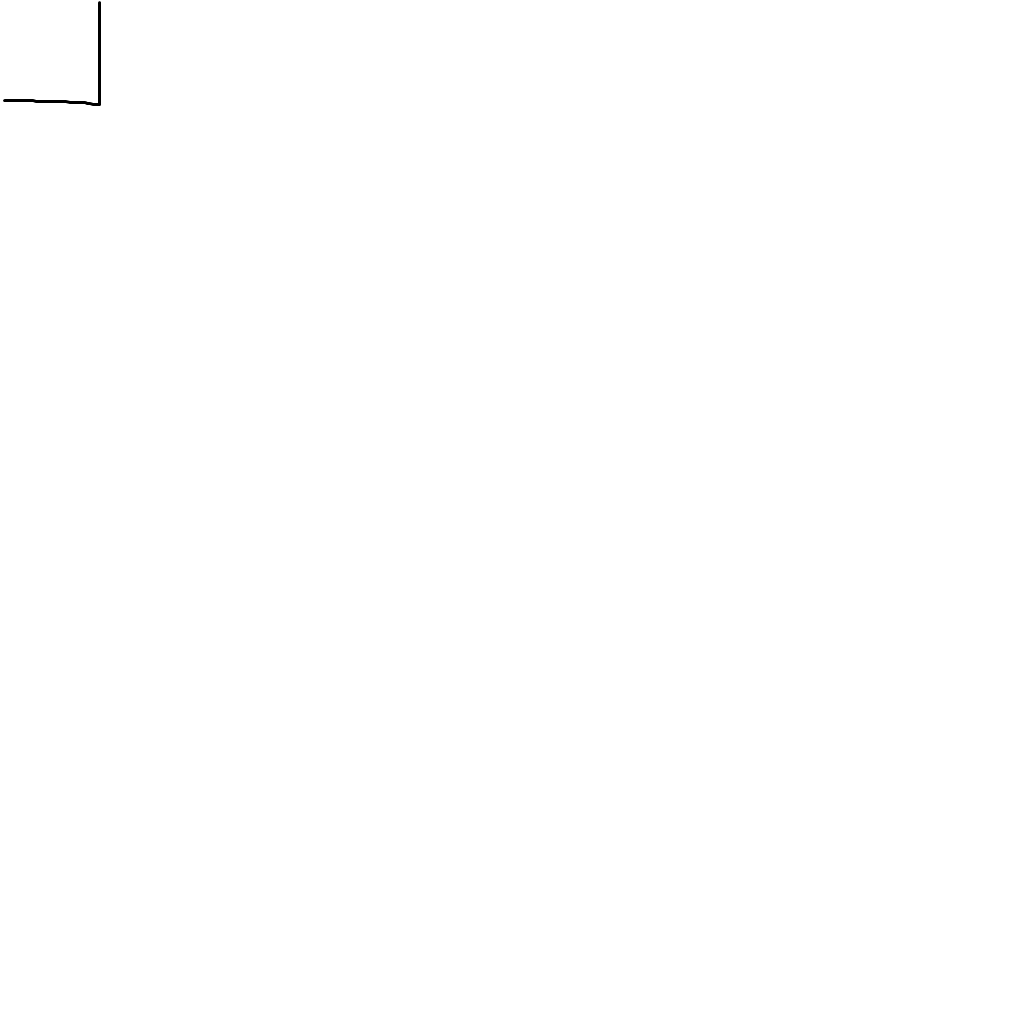

In [11]:
Image("/opt/ml/UniverseNet/example.png")

- test 이미지에 작은 물체가 별로 없다고 생각하면, 면적 비율에 따라 box를 제거해주면 mAP 향상을 기대해볼 수 있다.

- 면적 비율에 따라 bbox 제거 전략의 예상 기대 효과를 생각해본다면,, confidence threshold와 nms_iou_threshold에서 걸러지지 않은 수많은 bbox들의 비율을 많이 줄일 수 있다는 점이다 -> mAP 향상을 기대해볼 수 있다.

- 0.01 기준으로 bbox를 한 번 제거해보자. -> 시각화를 해보면 좋을 것 같아서, 한 번 시각화 해보자.

In [12]:
import cv2
import matplotlib.pyplot as plt

# 호찬님이 주신 코드
def all_visualization(path, num=10):
    df = pd.read_csv(path, index_col=False)
    class_dict = {0:'General trash', 1:'Paper', 2:'Paper pack', 3:'Metal', 4:'Glass',
                  5:'Plastic', 6:'Styrofoam', 7:'Plastic bag', 8:'Battery', 9:'Clothig'}
    class_colors = [(255, 153, 153), (255, 204, 153), (255, 255, 153),
                        (204, 255, 153), (153, 255, 255), (153, 153, 255),
                        (204, 153, 255), (255, 153, 255), (255, 153, 204), (255, 128, 0)]
    
    for idx, bboxes in enumerate(df['PredictionString'][:num]):
        image_path = '/opt/ml/dataset/' + df['image_id'][idx]
        images = cv2.imread(image_path)

        bbox = []
        temp =[]
        for text in bboxes.split(' '):
            if len(temp) < 6:
                temp.append(text)
            else:
                bbox.append(temp)
                temp = [text]
                
        for i in bbox:
            class_n, confidence, x_min, y_min, x_max, y_max = i
            images = cv2.rectangle(images, (int(float(x_min)), int(float(y_min))), (int(float(x_max)), int(float(y_max))), class_colors[int(class_n)], 2)
            images = cv2.putText(images, class_dict[int(class_n)], (int(float(x_min)), int(float(y_min))), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)

        plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
        plt.show()


In [ ]:
path = "/opt/ml/UniverseNet/work_dir/output.csv"
all_visualization(path)

In [14]:
# 작은 BBOX들을 지워본다면,,?
# CSV 파일 불러오기
import pandas as pd
from tqdm import tqdm

universenet_preds = pd.read_csv("/opt/ml/UniverseNet/work_dir/output.csv")

category_distribution_base = [0 for _ in range(10)]
category_distribution_under_threshold = [0 for _ in range(10)]

new_file_names = []
new_prediction_strings = []

orig_img_area = 1024 * 1024
for preds, file_name in zip(universenet_preds['PredictionString'], universenet_preds['image_id']):
    new_file_names.append(file_name)
    splitted_preds = preds.split()
    
    new_prediction_string = ''
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])
        x_min, y_min, x_max, y_max = [float(x) for x in splitted_preds[idx+2:idx+6]]

        # 면적 계산
        bbox_area = (x_max - x_min) * (y_max - y_min) # width * height
        ratio = bbox_area / orig_img_area

        # 전체 이미지 대비 면적이 0.005 이하라면
        if ratio <= 0.0005:
            continue

        # 0.01보다는 크다면
        new_prediction_string += str(category_id) + ' ' + str(confidence_score) + ' ' + str(x_min) + ' ' + str(y_min) + ' ' + str(x_max) + ' ' + str(y_max) + ' '
    
    new_prediction_strings.append(new_prediction_string)

In [15]:
import os

new_submission = pd.DataFrame()
new_submission['PredictionString'] = new_prediction_strings
new_submission['image_id'] = new_file_names

csv_path = '/opt/ml/postprocessing/'

if not os.path.exists(csv_path):
    os.mkdir(csv_path)

new_submission.to_csv(os.path.join(csv_path, 'test0.02.csv'), index=None)

In [22]:
# 만들었으니 다시 불러와보기
import pandas as pd

universenet_preds = pd.read_csv("/opt/ml/postprocessing/test0.01.csv")

category_distribution = [0 for _ in range(10)]

for preds in universenet_preds['PredictionString']:
    try:
        splitted_preds = preds.split()
    except:
        print(preds)
    
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])

        category_distribution[category_id] += 1

print(category_distribution, sum(category_distribution))

nan
nan
nan
nan
nan
nan
nan
[31124, 29062, 4806, 5507, 4678, 15638, 8470, 23674, 1466, 4701] 129126


- 약 80,000 개의 bbox를 줄일 수 있었음.
- 시각화를 해보자.

In [ ]:
path2 = '/opt/ml/postprocessing/test1.csv'
all_visualization(path2)

- LB에 제출했을 때 0.6383 -> 0.5586으로 대폭 떨어졌다.
- 되게 작은 bbox들 중에 gt인 box들이 많았나보다.
- 어쩌면 모델이 예측한 20만개의 box 중 불필요한 box를 특정 기준으로 솎아내는 것이 불가능할 수도 있겠다는 생각이 든다. -> 내가 설정한, manual한 기준으로 솎아내는 건 불가능한 게 맞는 것 같다.
- 오히려 너무 큰 박스들을 제거해본다면 어떨까??

- 마지막으로, 앙상블한 submission.csv에서 엄청 작거나 엄청 큰 bbox 들을 제거해보기로 했다.